# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

keywords are unexpanded, not using


In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  0.036265  0.726236  1.0  0.040308  0.088090 -0.485181  2  3  28.344445   
1 -1.220445  1.165878  1.0  0.787137  0.185648  0.217887  1  3  34.663976   
2 -0.329998  0.297116  0.0  0.568038 -0.518092 -0.650992  3  1  17.380595   
3 -1.257592  0.217625  1.0  0.478190 -0.267326 -0.802829  1  2  25.701175   
4 -0.254943  0.418890  0.0  0.484223 -1.645939  0.198594  3  2  16.962485   

            y  
0  302.226734  
1  331.397864  
2  172.658253  
3  231.928271  
4  172.942910  
True causal estimate is 9.944459330727204


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

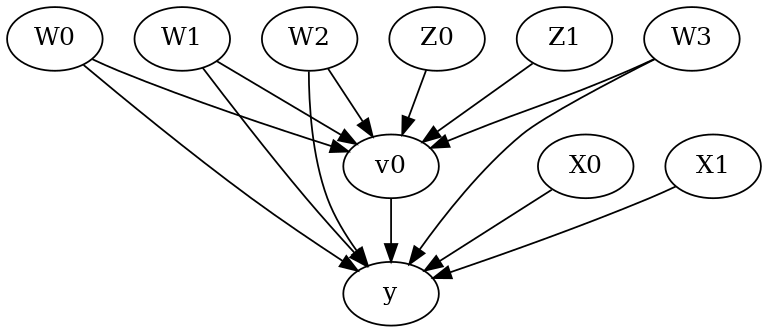

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X0', 'X1']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 9.944324771864991
### Conditional Estimates
__categorical__X0  __categorical__X1
(-4.561, -1.22]    (-2.895, 0.0762]      8.038803
                   (0.0762, 0.649]       8.429849
                   (0.649, 1.147]        8.551751
                   (1.147, 1.733]        8.756899
                   (1.733, 4.546]        9.067952
(-1.22, -0.635]    (-2.895, 0.0762]      8.952472
                   (0.0762, 0.649]       9.243239
                   (0.649, 1.147]        9.433327
                   (1.147, 1.733]        9.622303
                   (1.733, 4.546]        9.90715

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 11.710004043211766
Effect estimates: [11.84744875 11.2823419  11.63048333 11.3617034  11.28960828 12.46157926
 12.22250022 11.87811254 12.12122913 11.26283668 11.73395517 11.62589588
 11.53044472 11.27671699 12.86832337 12.20790694 11.70461749 11.68313484
 11.11369766 11.3819415  12.27323072 11.63109176 11.49542663 11.59184204
 11.78886218 10.98509291 11.41388919 12.13514347 11.68391131 12.33965528
 11.94334376 12.07258834 12.61061821 12.54140806 11.32557083 11.69222451
 11.46485527 12.13790481 11.52264693 11.51752982 12.27912874 11.20194405
 11.2

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 9.944459330727204


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X0,X1
Target units: 

## Estimate
Mean value: 9.896727638180268
Effect estimates: [10.24609369  9.16339066  9.72911285 ...  9.40281647  8.75658069
 10.75765995]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X0,X1
Target units: ate

## Estimate
Mean value: 9.883382323983996
Effect estimates: [10.24567248  9.1267638   9.73587029 ...  9.39748741  8.73022471
 10.702713  ]
95.0% confidence interval: (array([10.25036474,  9.06595213,  9.73000691, ...,  9.37768154,
        8.64826649, 10.66434054]), array([10.33549706,  9.15362102,  9.79756502, ...,  9.43760507,
        8.74568432, 10.81367502]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[10.33468141 10.48855236 10.73251603 10.51318998 11.01621243 10.71443966
 11.05311332 10.33188945 10.14183734 10.80483979]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.239731  1.566384  0.0  0.291365 -0.846509 -0.795392  0.213100   
1    -2.162119  0.604086  1.0  0.894747  0.509441  2.983017  0.609551   
2    -0.729034  0.462202  1.0  0.940993 -0.306941  0.231450 -0.177388   
3    -2.120970 -0.081209  1.0  0.590755 -1.379479  0.325564  3.139711   
4     0.268416 -0.146198  0.0  0.586561 -0.120895  0.355518  2.186571   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -2.100441  0.569790  0.0  0.818437  2.341098 -0.075852  0.624516   
9996 -0.631890  0.070346  0.0  0.444446  0.210747  0.745177 -0.924573   
9997 -0.375142  0.747687  0.0  0.175240  0.196443 -0.339696 -0.099604   
9998 -0.309435  0.813001  1.0  0.670973  1.126442 -0.565819  1.044825   
9999  0.254586 -0.832927  0.0  0.937003  1.041999  1.625700  0.531382   

            W3  v0  y  
0    -0.472634   1  1  
1    -0.572696   1  1  
2    -0.277395   1  1  
3     0.019214   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W2,W0,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W0,W1,U) = P(y|v0,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X0,X1
Target units: ate

## Estimate
Mean value: 0.4549623515936939
Effect estimates: [0.5981888  0.42298111 0.48296375 ... 0.52412276 0.53277652 0.42568008]

True causal estimate is 0.289


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-08-01 08:21:09.285120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-08-01 08:21:09.285158: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-08-01 08:21:10.817123: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-08-01 08:21:10.817162: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-01 08:21:10.817185: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cb1e06b45e4d): /proc/driver/nvidia/version does not exist
2022-08-01 08:21:10.817449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 3:28 - loss: 168.1448

 32/313 [==>...........................] - ETA: 0s - loss: 57.1593   

 65/313 [=====>........................] - ETA: 0s - loss: 30.8934

 98/313 [========>.....................] - ETA: 0s - loss: 22.0818

131/313 [===========>..................] - ETA: 0s - loss: 17.6504

163/313 [==============>...............] - ETA: 0s - loss: 15.0475

195/313 [=================>............] - ETA: 0s - loss: 13.2918

228/313 [====================>.........] - ETA: 0s - loss: 11.9800

261/313 [========================>.....] - ETA: 0s - loss: 10.9845

294/313 [===========================>..] - ETA: 0s - loss: 10.1995

313/313 [==============================] - 1s 2ms/step - loss: 9.8182


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 3.5663

 35/313 [==>...........................] - ETA: 0s - loss: 3.8542

 67/313 [=====>........................] - ETA: 0s - loss: 3.8258

100/313 [========>.....................] - ETA: 0s - loss: 3.7646

133/313 [===========>..................] - ETA: 0s - loss: 3.7035

166/313 [==============>...............] - ETA: 0s - loss: 3.6324

198/313 [=================>............] - ETA: 0s - loss: 3.5591

230/313 [=====================>........] - ETA: 0s - loss: 3.5044

262/313 [========================>.....] - ETA: 0s - loss: 3.4452

295/313 [===========================>..] - ETA: 0s - loss: 3.3980

313/313 [==============================] - 0s 2ms/step - loss: 3.3773


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 2.8943

 34/313 [==>...........................] - ETA: 0s - loss: 2.9873

 66/313 [=====>........................] - ETA: 0s - loss: 2.9542

 99/313 [========>.....................] - ETA: 0s - loss: 2.9694

131/313 [===========>..................] - ETA: 0s - loss: 2.9579

164/313 [==============>...............] - ETA: 0s - loss: 2.9630

196/313 [=================>............] - ETA: 0s - loss: 2.9576

227/313 [====================>.........] - ETA: 0s - loss: 2.9485

260/313 [=======================>......] - ETA: 0s - loss: 2.9412

292/313 [==========================>...] - ETA: 0s - loss: 2.9326

313/313 [==============================] - 0s 2ms/step - loss: 2.9278


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 2.9282

 34/313 [==>...........................] - ETA: 0s - loss: 2.8428

 66/313 [=====>........................] - ETA: 0s - loss: 2.8544

 99/313 [========>.....................] - ETA: 0s - loss: 2.8362

132/313 [===========>..................] - ETA: 0s - loss: 2.8321

164/313 [==============>...............] - ETA: 0s - loss: 2.8291

197/313 [=================>............] - ETA: 0s - loss: 2.8313

230/313 [=====================>........] - ETA: 0s - loss: 2.8335

263/313 [========================>.....] - ETA: 0s - loss: 2.8304

295/313 [===========================>..] - ETA: 0s - loss: 2.8242

313/313 [==============================] - 0s 2ms/step - loss: 2.8239


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.6551

 35/313 [==>...........................] - ETA: 0s - loss: 2.7725

 68/313 [=====>........................] - ETA: 0s - loss: 2.7900

100/313 [========>.....................] - ETA: 0s - loss: 2.7760

132/313 [===========>..................] - ETA: 0s - loss: 2.7767

165/313 [==============>...............] - ETA: 0s - loss: 2.7663

199/313 [==================>...........] - ETA: 0s - loss: 2.7696

233/313 [=====================>........] - ETA: 0s - loss: 2.7699

267/313 [========================>.....] - ETA: 0s - loss: 2.7704

301/313 [===========================>..] - ETA: 0s - loss: 2.7708

313/313 [==============================] - 0s 2ms/step - loss: 2.7696


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 2.7252

 35/313 [==>...........................] - ETA: 0s - loss: 2.7481

 68/313 [=====>........................] - ETA: 0s - loss: 2.7637

102/313 [========>.....................] - ETA: 0s - loss: 2.7490

135/313 [===========>..................] - ETA: 0s - loss: 2.7495

168/313 [===============>..............] - ETA: 0s - loss: 2.7529

201/313 [==================>...........] - ETA: 0s - loss: 2.7520

234/313 [=====================>........] - ETA: 0s - loss: 2.7485

268/313 [========================>.....] - ETA: 0s - loss: 2.7458

301/313 [===========================>..] - ETA: 0s - loss: 2.7448

313/313 [==============================] - 0s 2ms/step - loss: 2.7439


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.7310

 35/313 [==>...........................] - ETA: 0s - loss: 2.7141

 68/313 [=====>........................] - ETA: 0s - loss: 2.7266

101/313 [========>.....................] - ETA: 0s - loss: 2.7214

134/313 [===========>..................] - ETA: 0s - loss: 2.7287

167/313 [===============>..............] - ETA: 0s - loss: 2.7278

199/313 [==================>...........] - ETA: 0s - loss: 2.7275

232/313 [=====================>........] - ETA: 0s - loss: 2.7235

265/313 [========================>.....] - ETA: 0s - loss: 2.7245

298/313 [===========================>..] - ETA: 0s - loss: 2.7207

313/313 [==============================] - 0s 2ms/step - loss: 2.7211


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2.6730

 34/313 [==>...........................] - ETA: 0s - loss: 2.7177

 67/313 [=====>........................] - ETA: 0s - loss: 2.7121

100/313 [========>.....................] - ETA: 0s - loss: 2.7064

132/313 [===========>..................] - ETA: 0s - loss: 2.7153

165/313 [==============>...............] - ETA: 0s - loss: 2.7083

198/313 [=================>............] - ETA: 0s - loss: 2.7028

230/313 [=====================>........] - ETA: 0s - loss: 2.7075

263/313 [========================>.....] - ETA: 0s - loss: 2.7138

293/313 [===========================>..] - ETA: 0s - loss: 2.7085

313/313 [==============================] - 0s 2ms/step - loss: 2.7056


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.7999

 35/313 [==>...........................] - ETA: 0s - loss: 2.7404

 63/313 [=====>........................] - ETA: 0s - loss: 2.7283

 86/313 [=======>......................] - ETA: 0s - loss: 2.7209

119/313 [==========>...................] - ETA: 0s - loss: 2.7214

152/313 [=============>................] - ETA: 0s - loss: 2.7063

186/313 [================>.............] - ETA: 0s - loss: 2.6985

219/313 [===================>..........] - ETA: 0s - loss: 2.6982

251/313 [=======================>......] - ETA: 0s - loss: 2.6980

284/313 [==========================>...] - ETA: 0s - loss: 2.6911

313/313 [==============================] - 1s 2ms/step - loss: 2.6901


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 2.7035

 35/313 [==>...........................] - ETA: 0s - loss: 2.6802

 66/313 [=====>........................] - ETA: 0s - loss: 2.6588

 98/313 [========>.....................] - ETA: 0s - loss: 2.6653

131/313 [===========>..................] - ETA: 0s - loss: 2.6746

165/313 [==============>...............] - ETA: 0s - loss: 2.6741

198/313 [=================>............] - ETA: 0s - loss: 2.6685

231/313 [=====================>........] - ETA: 0s - loss: 2.6697

264/313 [========================>.....] - ETA: 0s - loss: 2.6687

297/313 [===========================>..] - ETA: 0s - loss: 2.6676

313/313 [==============================] - 0s 2ms/step - loss: 2.6711


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.8400

 34/313 [==>...........................] - ETA: 0s - loss: 2.6521

 67/313 [=====>........................] - ETA: 0s - loss: 2.6480

 99/313 [========>.....................] - ETA: 0s - loss: 2.6458

131/313 [===========>..................] - ETA: 0s - loss: 2.6479

164/313 [==============>...............] - ETA: 0s - loss: 2.6567

197/313 [=================>............] - ETA: 0s - loss: 2.6632

230/313 [=====================>........] - ETA: 0s - loss: 2.6612

263/313 [========================>.....] - ETA: 0s - loss: 2.6586

296/313 [===========================>..] - ETA: 0s - loss: 2.6618

313/313 [==============================] - 0s 2ms/step - loss: 2.6601


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 3.2242

 34/313 [==>...........................] - ETA: 0s - loss: 2.6391

 67/313 [=====>........................] - ETA: 0s - loss: 2.6638

100/313 [========>.....................] - ETA: 0s - loss: 2.6600

133/313 [===========>..................] - ETA: 0s - loss: 2.6667

166/313 [==============>...............] - ETA: 0s - loss: 2.6681

199/313 [==================>...........] - ETA: 0s - loss: 2.6606

231/313 [=====================>........] - ETA: 0s - loss: 2.6610

264/313 [========================>.....] - ETA: 0s - loss: 2.6664

298/313 [===========================>..] - ETA: 0s - loss: 2.6639

313/313 [==============================] - 0s 2ms/step - loss: 2.6645


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2.5538

 35/313 [==>...........................] - ETA: 0s - loss: 2.6498

 69/313 [=====>........................] - ETA: 0s - loss: 2.6587

103/313 [========>.....................] - ETA: 0s - loss: 2.6703

136/313 [============>.................] - ETA: 0s - loss: 2.6565

170/313 [===============>..............] - ETA: 0s - loss: 2.6579

204/313 [==================>...........] - ETA: 0s - loss: 2.6535

237/313 [=====================>........] - ETA: 0s - loss: 2.6550

270/313 [========================>.....] - ETA: 0s - loss: 2.6529

303/313 [============================>.] - ETA: 0s - loss: 2.6514

313/313 [==============================] - 0s 2ms/step - loss: 2.6520


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.4641

 35/313 [==>...........................] - ETA: 0s - loss: 2.6215

 68/313 [=====>........................] - ETA: 0s - loss: 2.6205

101/313 [========>.....................] - ETA: 0s - loss: 2.6144

133/313 [===========>..................] - ETA: 0s - loss: 2.6138

167/313 [===============>..............] - ETA: 0s - loss: 2.6176

201/313 [==================>...........] - ETA: 0s - loss: 2.6178

234/313 [=====================>........] - ETA: 0s - loss: 2.6225

267/313 [========================>.....] - ETA: 0s - loss: 2.6235

300/313 [===========================>..] - ETA: 0s - loss: 2.6304

313/313 [==============================] - 0s 2ms/step - loss: 2.6326


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.5697

 35/313 [==>...........................] - ETA: 0s - loss: 2.5967

 68/313 [=====>........................] - ETA: 0s - loss: 2.6162

102/313 [========>.....................] - ETA: 0s - loss: 2.6281

135/313 [===========>..................] - ETA: 0s - loss: 2.6334

168/313 [===============>..............] - ETA: 0s - loss: 2.6345

201/313 [==================>...........] - ETA: 0s - loss: 2.6366

234/313 [=====================>........] - ETA: 0s - loss: 2.6351

267/313 [========================>.....] - ETA: 0s - loss: 2.6349

300/313 [===========================>..] - ETA: 0s - loss: 2.6342

313/313 [==============================] - 0s 2ms/step - loss: 2.6330


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 2.8416

 35/313 [==>...........................] - ETA: 0s - loss: 2.6241

 68/313 [=====>........................] - ETA: 0s - loss: 2.6601

101/313 [========>.....................] - ETA: 0s - loss: 2.6509

134/313 [===========>..................] - ETA: 0s - loss: 2.6373

167/313 [===============>..............] - ETA: 0s - loss: 2.6295

200/313 [==================>...........] - ETA: 0s - loss: 2.6286

234/313 [=====================>........] - ETA: 0s - loss: 2.6264

267/313 [========================>.....] - ETA: 0s - loss: 2.6265

301/313 [===========================>..] - ETA: 0s - loss: 2.6290

313/313 [==============================] - 0s 2ms/step - loss: 2.6268


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.4692

 34/313 [==>...........................] - ETA: 0s - loss: 2.6086

 66/313 [=====>........................] - ETA: 0s - loss: 2.6276

 99/313 [========>.....................] - ETA: 0s - loss: 2.6272

132/313 [===========>..................] - ETA: 0s - loss: 2.6245

165/313 [==============>...............] - ETA: 0s - loss: 2.6201

199/313 [==================>...........] - ETA: 0s - loss: 2.6203

233/313 [=====================>........] - ETA: 0s - loss: 2.6179

266/313 [========================>.....] - ETA: 0s - loss: 2.6189

299/313 [===========================>..] - ETA: 0s - loss: 2.6189

313/313 [==============================] - 0s 2ms/step - loss: 2.6178


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.6627

 34/313 [==>...........................] - ETA: 0s - loss: 2.6199

 67/313 [=====>........................] - ETA: 0s - loss: 2.5997

101/313 [========>.....................] - ETA: 0s - loss: 2.5860

134/313 [===========>..................] - ETA: 0s - loss: 2.5948

167/313 [===============>..............] - ETA: 0s - loss: 2.6010

200/313 [==================>...........] - ETA: 0s - loss: 2.5990

233/313 [=====================>........] - ETA: 0s - loss: 2.5983

266/313 [========================>.....] - ETA: 0s - loss: 2.6030

299/313 [===========================>..] - ETA: 0s - loss: 2.6068

313/313 [==============================] - 0s 2ms/step - loss: 2.6072


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.3663

 35/313 [==>...........................] - ETA: 0s - loss: 2.6259

 67/313 [=====>........................] - ETA: 0s - loss: 2.6273

100/313 [========>.....................] - ETA: 0s - loss: 2.6142

132/313 [===========>..................] - ETA: 0s - loss: 2.6124

165/313 [==============>...............] - ETA: 0s - loss: 2.6198

198/313 [=================>............] - ETA: 0s - loss: 2.6162

231/313 [=====================>........] - ETA: 0s - loss: 2.6159

264/313 [========================>.....] - ETA: 0s - loss: 2.6137

297/313 [===========================>..] - ETA: 0s - loss: 2.6132

313/313 [==============================] - 0s 2ms/step - loss: 2.6113


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 2.3909

 35/313 [==>...........................] - ETA: 0s - loss: 2.5711

 68/313 [=====>........................] - ETA: 0s - loss: 2.5825

101/313 [========>.....................] - ETA: 0s - loss: 2.5844

134/313 [===========>..................] - ETA: 0s - loss: 2.5939

168/313 [===============>..............] - ETA: 0s - loss: 2.5935

201/313 [==================>...........] - ETA: 0s - loss: 2.5946

234/313 [=====================>........] - ETA: 0s - loss: 2.5938

267/313 [========================>.....] - ETA: 0s - loss: 2.5930

300/313 [===========================>..] - ETA: 0s - loss: 2.5935

313/313 [==============================] - 0s 2ms/step - loss: 2.5926


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.5381

 34/313 [==>...........................] - ETA: 0s - loss: 2.5940

 67/313 [=====>........................] - ETA: 0s - loss: 2.5947

100/313 [========>.....................] - ETA: 0s - loss: 2.5876

134/313 [===========>..................] - ETA: 0s - loss: 2.5906

167/313 [===============>..............] - ETA: 0s - loss: 2.6003

200/313 [==================>...........] - ETA: 0s - loss: 2.6046

233/313 [=====================>........] - ETA: 0s - loss: 2.6004

266/313 [========================>.....] - ETA: 0s - loss: 2.5990

299/313 [===========================>..] - ETA: 0s - loss: 2.5951

313/313 [==============================] - 0s 2ms/step - loss: 2.5969


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.5713

 34/313 [==>...........................] - ETA: 0s - loss: 2.6174

 67/313 [=====>........................] - ETA: 0s - loss: 2.6067

100/313 [========>.....................] - ETA: 0s - loss: 2.5930

133/313 [===========>..................] - ETA: 0s - loss: 2.5927

167/313 [===============>..............] - ETA: 0s - loss: 2.5958

198/313 [=================>............] - ETA: 0s - loss: 2.5955

232/313 [=====================>........] - ETA: 0s - loss: 2.5984

266/313 [========================>.....] - ETA: 0s - loss: 2.5984

299/313 [===========================>..] - ETA: 0s - loss: 2.5976

313/313 [==============================] - 0s 2ms/step - loss: 2.5970


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.6102

 34/313 [==>...........................] - ETA: 0s - loss: 2.5751

 67/313 [=====>........................] - ETA: 0s - loss: 2.5852

100/313 [========>.....................] - ETA: 0s - loss: 2.5888

133/313 [===========>..................] - ETA: 0s - loss: 2.5887

166/313 [==============>...............] - ETA: 0s - loss: 2.5897

199/313 [==================>...........] - ETA: 0s - loss: 2.5919

231/313 [=====================>........] - ETA: 0s - loss: 2.5967

264/313 [========================>.....] - ETA: 0s - loss: 2.5953

296/313 [===========================>..] - ETA: 0s - loss: 2.5903

313/313 [==============================] - 0s 2ms/step - loss: 2.5904


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 2.5092

 35/313 [==>...........................] - ETA: 0s - loss: 2.5916

 68/313 [=====>........................] - ETA: 0s - loss: 2.5967

101/313 [========>.....................] - ETA: 0s - loss: 2.6007

134/313 [===========>..................] - ETA: 0s - loss: 2.5949

168/313 [===============>..............] - ETA: 0s - loss: 2.5945

202/313 [==================>...........] - ETA: 0s - loss: 2.5888

235/313 [=====================>........] - ETA: 0s - loss: 2.5919

268/313 [========================>.....] - ETA: 0s - loss: 2.5930

301/313 [===========================>..] - ETA: 0s - loss: 2.5946

313/313 [==============================] - 0s 2ms/step - loss: 2.5923


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2.4609

 35/313 [==>...........................] - ETA: 0s - loss: 2.5969

 68/313 [=====>........................] - ETA: 0s - loss: 2.5874

101/313 [========>.....................] - ETA: 0s - loss: 2.5904

134/313 [===========>..................] - ETA: 0s - loss: 2.5812

166/313 [==============>...............] - ETA: 0s - loss: 2.5835

199/313 [==================>...........] - ETA: 0s - loss: 2.5849

232/313 [=====================>........] - ETA: 0s - loss: 2.5843

265/313 [========================>.....] - ETA: 0s - loss: 2.5835

298/313 [===========================>..] - ETA: 0s - loss: 2.5822

313/313 [==============================] - 0s 2ms/step - loss: 2.5865


Epoch 1/25


  1/313 [..............................] - ETA: 3:59 - loss: 45863.4141

 28/313 [=>............................] - ETA: 0s - loss: 46802.0703  

 55/313 [====>.........................] - ETA: 0s - loss: 38202.0117

 82/313 [======>.......................] - ETA: 0s - loss: 30623.4453

109/313 [=========>....................] - ETA: 0s - loss: 26706.3633

137/313 [============>.................] - ETA: 0s - loss: 23950.7188

165/313 [==============>...............] - ETA: 0s - loss: 22338.4609

193/313 [=================>............] - ETA: 0s - loss: 21106.5332

220/313 [====================>.........] - ETA: 0s - loss: 20221.7305

247/313 [======================>.......] - ETA: 0s - loss: 19353.4180

275/313 [=========================>....] - ETA: 0s - loss: 18677.5547

303/313 [============================>.] - ETA: 0s - loss: 18166.3613

313/313 [==============================] - 1s 2ms/step - loss: 17927.9609


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 11563.8516

 29/313 [=>............................] - ETA: 0s - loss: 12337.7725

 55/313 [====>.........................] - ETA: 0s - loss: 11673.9160

 81/313 [======>.......................] - ETA: 0s - loss: 11694.5762

108/313 [=========>....................] - ETA: 0s - loss: 11629.8271

136/313 [============>.................] - ETA: 0s - loss: 11487.2471

164/313 [==============>...............] - ETA: 0s - loss: 11461.4219

192/313 [=================>............] - ETA: 0s - loss: 11478.3447

220/313 [====================>.........] - ETA: 0s - loss: 11468.0566

247/313 [======================>.......] - ETA: 0s - loss: 11377.6562

270/313 [========================>.....] - ETA: 0s - loss: 11292.0283

298/313 [===========================>..] - ETA: 0s - loss: 11237.1650

313/313 [==============================] - 1s 2ms/step - loss: 11209.9531


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 14814.3662

 29/313 [=>............................] - ETA: 0s - loss: 11074.1289

 57/313 [====>.........................] - ETA: 0s - loss: 10784.9346

 85/313 [=======>......................] - ETA: 0s - loss: 10670.5547

113/313 [=========>....................] - ETA: 0s - loss: 10590.9668

141/313 [============>.................] - ETA: 0s - loss: 10558.7402

169/313 [===============>..............] - ETA: 0s - loss: 10584.6279

197/313 [=================>............] - ETA: 0s - loss: 10567.0566

224/313 [====================>.........] - ETA: 0s - loss: 10496.9990

252/313 [=======================>......] - ETA: 0s - loss: 10481.0342

280/313 [=========================>....] - ETA: 0s - loss: 10467.6416

308/313 [============================>.] - ETA: 0s - loss: 10550.4062

313/313 [==============================] - 1s 2ms/step - loss: 10588.7266


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 11162.7676

 29/313 [=>............................] - ETA: 0s - loss: 10410.7100

 57/313 [====>.........................] - ETA: 0s - loss: 10591.2383

 85/313 [=======>......................] - ETA: 0s - loss: 10482.2197

113/313 [=========>....................] - ETA: 0s - loss: 10382.2773

141/313 [============>.................] - ETA: 0s - loss: 10255.0225

169/313 [===============>..............] - ETA: 0s - loss: 10259.3857

197/313 [=================>............] - ETA: 0s - loss: 10349.5352

225/313 [====================>.........] - ETA: 0s - loss: 10245.1025

253/313 [=======================>......] - ETA: 0s - loss: 10225.2725

280/313 [=========================>....] - ETA: 0s - loss: 10175.7861

307/313 [============================>.] - ETA: 0s - loss: 10244.5225

313/313 [==============================] - 1s 2ms/step - loss: 10238.6211


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 7415.6299

 30/313 [=>............................] - ETA: 0s - loss: 10635.1602

 58/313 [====>.........................] - ETA: 0s - loss: 10719.3926

 86/313 [=======>......................] - ETA: 0s - loss: 10457.1064

114/313 [=========>....................] - ETA: 0s - loss: 10377.9131

142/313 [============>.................] - ETA: 0s - loss: 10178.4834

170/313 [===============>..............] - ETA: 0s - loss: 10084.0938

196/313 [=================>............] - ETA: 0s - loss: 10122.1572

223/313 [====================>.........] - ETA: 0s - loss: 10059.4863

251/313 [=======================>......] - ETA: 0s - loss: 10107.3418

279/313 [=========================>....] - ETA: 0s - loss: 10195.5234

306/313 [============================>.] - ETA: 0s - loss: 10186.3574

313/313 [==============================] - 1s 2ms/step - loss: 10226.0801


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 7934.4902

 29/313 [=>............................] - ETA: 0s - loss: 10331.2852

 57/313 [====>.........................] - ETA: 0s - loss: 10191.2891

 85/313 [=======>......................] - ETA: 0s - loss: 10055.3408

113/313 [=========>....................] - ETA: 0s - loss: 10185.1113

141/313 [============>.................] - ETA: 0s - loss: 10293.0703

169/313 [===============>..............] - ETA: 0s - loss: 10214.6992

197/313 [=================>............] - ETA: 0s - loss: 10204.7549

225/313 [====================>.........] - ETA: 0s - loss: 10222.3486

253/313 [=======================>......] - ETA: 0s - loss: 10180.2676

281/313 [=========================>....] - ETA: 0s - loss: 10174.7949

308/313 [============================>.] - ETA: 0s - loss: 10183.8330

313/313 [==============================] - 1s 2ms/step - loss: 10176.4727


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 14536.1416

 29/313 [=>............................] - ETA: 0s - loss: 11505.3809

 56/313 [====>.........................] - ETA: 0s - loss: 10544.4189

 84/313 [=======>......................] - ETA: 0s - loss: 10427.1709

111/313 [=========>....................] - ETA: 0s - loss: 10377.8447

139/313 [============>.................] - ETA: 0s - loss: 10239.5654

167/313 [===============>..............] - ETA: 0s - loss: 10313.8701

195/313 [=================>............] - ETA: 0s - loss: 10374.8838

223/313 [====================>.........] - ETA: 0s - loss: 10451.1367

251/313 [=======================>......] - ETA: 0s - loss: 10386.8008

279/313 [=========================>....] - ETA: 0s - loss: 10401.3369

307/313 [============================>.] - ETA: 0s - loss: 10387.4551

313/313 [==============================] - 1s 2ms/step - loss: 10376.3418


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 8868.6250

 29/313 [=>............................] - ETA: 0s - loss: 10236.5625

 57/313 [====>.........................] - ETA: 0s - loss: 9949.8428 

 84/313 [=======>......................] - ETA: 0s - loss: 9912.3379

112/313 [=========>....................] - ETA: 0s - loss: 10066.5713

140/313 [============>.................] - ETA: 0s - loss: 10038.5479

168/313 [===============>..............] - ETA: 0s - loss: 10010.1182

196/313 [=================>............] - ETA: 0s - loss: 10057.2051

224/313 [====================>.........] - ETA: 0s - loss: 10045.8652

252/313 [=======================>......] - ETA: 0s - loss: 10190.9873

280/313 [=========================>....] - ETA: 0s - loss: 10215.0537

308/313 [============================>.] - ETA: 0s - loss: 10218.6641

313/313 [==============================] - 1s 2ms/step - loss: 10214.1895


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 14027.5566

 29/313 [=>............................] - ETA: 0s - loss: 10352.8545

 57/313 [====>.........................] - ETA: 0s - loss: 9779.6094 

 85/313 [=======>......................] - ETA: 0s - loss: 9895.3105

113/313 [=========>....................] - ETA: 0s - loss: 10016.5244

141/313 [============>.................] - ETA: 0s - loss: 10021.5693

168/313 [===============>..............] - ETA: 0s - loss: 9976.8613 

195/313 [=================>............] - ETA: 0s - loss: 9995.9541

223/313 [====================>.........] - ETA: 0s - loss: 9992.3916

251/313 [=======================>......] - ETA: 0s - loss: 9968.2402

279/313 [=========================>....] - ETA: 0s - loss: 10023.8750

307/313 [============================>.] - ETA: 0s - loss: 9968.1934 

313/313 [==============================] - 1s 2ms/step - loss: 9950.8506


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 16404.6328

 29/313 [=>............................] - ETA: 0s - loss: 10704.7705

 57/313 [====>.........................] - ETA: 0s - loss: 10314.7109

 85/313 [=======>......................] - ETA: 0s - loss: 10158.8809

112/313 [=========>....................] - ETA: 0s - loss: 10106.8066

140/313 [============>.................] - ETA: 0s - loss: 10084.5811

167/313 [===============>..............] - ETA: 0s - loss: 10155.3262

195/313 [=================>............] - ETA: 0s - loss: 10136.5664

223/313 [====================>.........] - ETA: 0s - loss: 10106.7510

251/313 [=======================>......] - ETA: 0s - loss: 10068.2715

278/313 [=========================>....] - ETA: 0s - loss: 10123.6348

306/313 [============================>.] - ETA: 0s - loss: 10121.8096

313/313 [==============================] - 1s 2ms/step - loss: 10110.9854


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 11031.0117

 29/313 [=>............................] - ETA: 0s - loss: 10242.7510

 56/313 [====>.........................] - ETA: 0s - loss: 10496.9971

 84/313 [=======>......................] - ETA: 0s - loss: 10790.1738

112/313 [=========>....................] - ETA: 0s - loss: 10710.5957

140/313 [============>.................] - ETA: 0s - loss: 10568.1064

167/313 [===============>..............] - ETA: 0s - loss: 10554.0332

195/313 [=================>............] - ETA: 0s - loss: 10430.9932

223/313 [====================>.........] - ETA: 0s - loss: 10369.0020

251/313 [=======================>......] - ETA: 0s - loss: 10269.5352

279/313 [=========================>....] - ETA: 0s - loss: 10257.5068

307/313 [============================>.] - ETA: 0s - loss: 10283.0098

313/313 [==============================] - 1s 2ms/step - loss: 10268.6592


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 10904.3711

 29/313 [=>............................] - ETA: 0s - loss: 10073.6875

 57/313 [====>.........................] - ETA: 0s - loss: 9668.2910 

 85/313 [=======>......................] - ETA: 0s - loss: 9880.9180

111/313 [=========>....................] - ETA: 0s - loss: 9955.3760

139/313 [============>.................] - ETA: 0s - loss: 9957.2861

167/313 [===============>..............] - ETA: 0s - loss: 10190.1523

195/313 [=================>............] - ETA: 0s - loss: 10203.1963

223/313 [====================>.........] - ETA: 0s - loss: 10186.9902

251/313 [=======================>......] - ETA: 0s - loss: 10193.0215

279/313 [=========================>....] - ETA: 0s - loss: 10154.6211

307/313 [============================>.] - ETA: 0s - loss: 10183.0176

313/313 [==============================] - 1s 2ms/step - loss: 10171.7998


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 10479.4102

 29/313 [=>............................] - ETA: 0s - loss: 10411.4043

 56/313 [====>.........................] - ETA: 0s - loss: 9752.6113 

 81/313 [======>.......................] - ETA: 0s - loss: 9866.9570

108/313 [=========>....................] - ETA: 0s - loss: 9811.0254

135/313 [===========>..................] - ETA: 0s - loss: 9907.0078

163/313 [==============>...............] - ETA: 0s - loss: 10007.2793

190/313 [=================>............] - ETA: 0s - loss: 10070.7266

217/313 [===================>..........] - ETA: 0s - loss: 10083.6650

244/313 [======================>.......] - ETA: 0s - loss: 10129.4355

270/313 [========================>.....] - ETA: 0s - loss: 10062.7559

297/313 [===========================>..] - ETA: 0s - loss: 10095.5820

313/313 [==============================] - 1s 2ms/step - loss: 10123.4775


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 12621.9121

 29/313 [=>............................] - ETA: 0s - loss: 10467.8662

 57/313 [====>.........................] - ETA: 0s - loss: 10079.2129

 85/313 [=======>......................] - ETA: 0s - loss: 9943.3438 

113/313 [=========>....................] - ETA: 0s - loss: 9871.0439

141/313 [============>.................] - ETA: 0s - loss: 9931.4150

169/313 [===============>..............] - ETA: 0s - loss: 9963.4531

197/313 [=================>............] - ETA: 0s - loss: 9993.9570

225/313 [====================>.........] - ETA: 0s - loss: 10075.4365

253/313 [=======================>......] - ETA: 0s - loss: 10078.4111

281/313 [=========================>....] - ETA: 0s - loss: 10046.8486

309/313 [============================>.] - ETA: 0s - loss: 10036.5127

313/313 [==============================] - 1s 2ms/step - loss: 10069.0459


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 9663.4473

 29/313 [=>............................] - ETA: 0s - loss: 10607.9375

 57/313 [====>.........................] - ETA: 0s - loss: 10400.9541

 85/313 [=======>......................] - ETA: 0s - loss: 10358.6035

112/313 [=========>....................] - ETA: 0s - loss: 10286.4844

140/313 [============>.................] - ETA: 0s - loss: 10203.8438

168/313 [===============>..............] - ETA: 0s - loss: 10112.2783

196/313 [=================>............] - ETA: 0s - loss: 10174.8984

224/313 [====================>.........] - ETA: 0s - loss: 10123.6738

251/313 [=======================>......] - ETA: 0s - loss: 10156.7920

279/313 [=========================>....] - ETA: 0s - loss: 10119.0234

307/313 [============================>.] - ETA: 0s - loss: 10168.6348

313/313 [==============================] - 1s 2ms/step - loss: 10182.7158


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 5245.2827

 25/313 [=>............................] - ETA: 0s - loss: 10279.5371

 53/313 [====>.........................] - ETA: 0s - loss: 10157.2314

 81/313 [======>.......................] - ETA: 0s - loss: 10079.3477

109/313 [=========>....................] - ETA: 0s - loss: 9952.4912 

137/313 [============>.................] - ETA: 0s - loss: 10176.8008

165/313 [==============>...............] - ETA: 0s - loss: 10116.4170

193/313 [=================>............] - ETA: 0s - loss: 10082.5498

221/313 [====================>.........] - ETA: 0s - loss: 10181.0527

248/313 [======================>.......] - ETA: 0s - loss: 10101.6924

275/313 [=========================>....] - ETA: 0s - loss: 10042.8486

302/313 [===========================>..] - ETA: 0s - loss: 10027.5352

313/313 [==============================] - 1s 2ms/step - loss: 10009.7070


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 9655.6680

 29/313 [=>............................] - ETA: 0s - loss: 10383.4805

 56/313 [====>.........................] - ETA: 0s - loss: 10106.0889

 83/313 [======>.......................] - ETA: 0s - loss: 10248.0273

111/313 [=========>....................] - ETA: 0s - loss: 10158.1475

138/313 [============>.................] - ETA: 0s - loss: 10246.5342

166/313 [==============>...............] - ETA: 0s - loss: 10209.0410

193/313 [=================>............] - ETA: 0s - loss: 10171.7812

220/313 [====================>.........] - ETA: 0s - loss: 10091.8027

248/313 [======================>.......] - ETA: 0s - loss: 10094.4990

275/313 [=========================>....] - ETA: 0s - loss: 10158.8447

303/313 [============================>.] - ETA: 0s - loss: 10092.8398

313/313 [==============================] - 1s 2ms/step - loss: 10061.7627


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 10033.4824

 29/313 [=>............................] - ETA: 0s - loss: 10865.7158

 57/313 [====>.........................] - ETA: 0s - loss: 10574.6611

 85/313 [=======>......................] - ETA: 0s - loss: 10223.9385

113/313 [=========>....................] - ETA: 0s - loss: 10383.1865

141/313 [============>.................] - ETA: 0s - loss: 10356.5908

168/313 [===============>..............] - ETA: 0s - loss: 10251.3047

195/313 [=================>............] - ETA: 0s - loss: 10206.5811

222/313 [====================>.........] - ETA: 0s - loss: 10263.7852

250/313 [======================>.......] - ETA: 0s - loss: 10256.3594

278/313 [=========================>....] - ETA: 0s - loss: 10230.2490

305/313 [============================>.] - ETA: 0s - loss: 10270.4521

313/313 [==============================] - 1s 2ms/step - loss: 10249.9248


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 11365.5859

 29/313 [=>............................] - ETA: 0s - loss: 9816.2979 

 57/313 [====>.........................] - ETA: 0s - loss: 9687.3037

 85/313 [=======>......................] - ETA: 0s - loss: 10053.5781

112/313 [=========>....................] - ETA: 0s - loss: 10018.3857

140/313 [============>.................] - ETA: 0s - loss: 10056.7051

167/313 [===============>..............] - ETA: 0s - loss: 10142.3281

195/313 [=================>............] - ETA: 0s - loss: 10146.9062

223/313 [====================>.........] - ETA: 0s - loss: 10142.1445

251/313 [=======================>......] - ETA: 0s - loss: 10140.4141

279/313 [=========================>....] - ETA: 0s - loss: 10142.2559

306/313 [============================>.] - ETA: 0s - loss: 10157.5273

313/313 [==============================] - 1s 2ms/step - loss: 10199.4453


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 11485.1328

 29/313 [=>............................] - ETA: 0s - loss: 10186.5918

 57/313 [====>.........................] - ETA: 0s - loss: 9738.7070 

 84/313 [=======>......................] - ETA: 0s - loss: 9892.8926

112/313 [=========>....................] - ETA: 0s - loss: 10139.6240

140/313 [============>.................] - ETA: 0s - loss: 10177.1270

168/313 [===============>..............] - ETA: 0s - loss: 10221.9648

195/313 [=================>............] - ETA: 0s - loss: 10159.5107

223/313 [====================>.........] - ETA: 0s - loss: 10171.5889

251/313 [=======================>......] - ETA: 0s - loss: 10150.5176

278/313 [=========================>....] - ETA: 0s - loss: 10094.5322

305/313 [============================>.] - ETA: 0s - loss: 10080.6055

313/313 [==============================] - 1s 2ms/step - loss: 10104.4180


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 7497.0835

 29/313 [=>............................] - ETA: 0s - loss: 9230.5938

 57/313 [====>.........................] - ETA: 0s - loss: 10150.7109

 85/313 [=======>......................] - ETA: 0s - loss: 9954.7363 

113/313 [=========>....................] - ETA: 0s - loss: 9965.4648

141/313 [============>.................] - ETA: 0s - loss: 10156.1104

169/313 [===============>..............] - ETA: 0s - loss: 10138.2793

197/313 [=================>............] - ETA: 0s - loss: 10199.0840

225/313 [====================>.........] - ETA: 0s - loss: 10242.1260

252/313 [=======================>......] - ETA: 0s - loss: 10283.5508

280/313 [=========================>....] - ETA: 0s - loss: 10240.4326

308/313 [============================>.] - ETA: 0s - loss: 10148.3750

313/313 [==============================] - 1s 2ms/step - loss: 10142.4893


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 6036.5645

 28/313 [=>............................] - ETA: 0s - loss: 10931.7109

 55/313 [====>.........................] - ETA: 0s - loss: 10854.1309

 82/313 [======>.......................] - ETA: 0s - loss: 10506.5781

110/313 [=========>....................] - ETA: 0s - loss: 10320.7998

138/313 [============>.................] - ETA: 0s - loss: 10297.4814

166/313 [==============>...............] - ETA: 0s - loss: 10227.6484

194/313 [=================>............] - ETA: 0s - loss: 10182.7852

222/313 [====================>.........] - ETA: 0s - loss: 10182.1670

250/313 [======================>.......] - ETA: 0s - loss: 10173.1025

278/313 [=========================>....] - ETA: 0s - loss: 10194.4629

306/313 [============================>.] - ETA: 0s - loss: 10247.2451

313/313 [==============================] - 1s 2ms/step - loss: 10249.6055


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 6853.7012

 29/313 [=>............................] - ETA: 0s - loss: 9768.6475

 50/313 [===>..........................] - ETA: 0s - loss: 9998.4570

 78/313 [======>.......................] - ETA: 0s - loss: 10149.1367

106/313 [=========>....................] - ETA: 0s - loss: 10160.7822

134/313 [===========>..................] - ETA: 0s - loss: 10277.5889

161/313 [==============>...............] - ETA: 0s - loss: 10021.8740

189/313 [=================>............] - ETA: 0s - loss: 9908.6025 

217/313 [===================>..........] - ETA: 0s - loss: 9928.5986

245/313 [======================>.......] - ETA: 0s - loss: 9974.0625

273/313 [=========================>....] - ETA: 0s - loss: 10024.5547

300/313 [===========================>..] - ETA: 0s - loss: 10035.4609

313/313 [==============================] - 1s 2ms/step - loss: 10038.6875


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 12993.9082

 29/313 [=>............................] - ETA: 0s - loss: 10338.9609

 56/313 [====>.........................] - ETA: 0s - loss: 10449.2979

 84/313 [=======>......................] - ETA: 0s - loss: 10405.9082

111/313 [=========>....................] - ETA: 0s - loss: 10269.9541

139/313 [============>.................] - ETA: 0s - loss: 10297.2080

167/313 [===============>..............] - ETA: 0s - loss: 10156.2344

195/313 [=================>............] - ETA: 0s - loss: 10190.0557

223/313 [====================>.........] - ETA: 0s - loss: 10164.3926

251/313 [=======================>......] - ETA: 0s - loss: 10073.8779

279/313 [=========================>....] - ETA: 0s - loss: 10085.5557

307/313 [============================>.] - ETA: 0s - loss: 10085.7227

313/313 [==============================] - 1s 2ms/step - loss: 10075.6758


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 7464.1831

 30/313 [=>............................] - ETA: 0s - loss: 10018.6514

 58/313 [====>.........................] - ETA: 0s - loss: 9991.8057 

 86/313 [=======>......................] - ETA: 0s - loss: 10012.4160

114/313 [=========>....................] - ETA: 0s - loss: 10051.6133

142/313 [============>.................] - ETA: 0s - loss: 9925.9453 

170/313 [===============>..............] - ETA: 0s - loss: 10112.9238

198/313 [=================>............] - ETA: 0s - loss: 10082.6758

226/313 [====================>.........] - ETA: 0s - loss: 10006.4785

254/313 [=======================>......] - ETA: 0s - loss: 9987.4229 

282/313 [==========================>...] - ETA: 0s - loss: 9968.3711

310/313 [============================>.] - ETA: 0s - loss: 9999.2139

313/313 [==============================] - 1s 2ms/step - loss: 10006.0049


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/230 [..............................] - ETA: 17s

 62/230 [=======>......................] - ETA: 0s 

123/230 [===============>..............] - ETA: 0s

185/230 [=======================>......] - ETA: 0s

230/230 [==============================] - 0s 817us/step


  1/230 [..............................] - ETA: 3s

 60/230 [======>.......................] - ETA: 0s

120/230 [==============>...............] - ETA: 0s

181/230 [======================>.......] - ETA: 0s

230/230 [==============================] - 0s 835us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W2+W0+W1 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 1.3823548555374146
Effect estimates: [1.2550964 1.0140076 1.049614  ... 1.2021484 0.9391022 1.7110901]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     0.578326  1.580099 -1.057306 -0.570966  0.153128  0.0  0.977561   
1    -0.950199  1.850572 -0.352590 -0.652694 -1.556932  0.0  0.461343   
2    -0.957321  2.089681  1.607485  0.485154 -2.114224  0.0  0.153576   
3    -0.909297  0.897539  0.964708 -1.702689  1.356044  0.0  0.525438   
4     0.496309  0.456921 -0.025093 -0.114414  0.167853  0.0  0.369552   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -2.587619  2.086274  1.626079  0.343364 -0.522462  0.0  0.256148   
9996 -0.642274  0.707593 -0.090046  1.571669  0.775667  0.0  0.947559   
9997  0.541141  1.528863  1.573505 -0.143670 -1.390047  0.0  0.493521   
9998 -1.411516  1.399885  1.271370 -2.226346 -1.056650  0.0  0.164465   
9999 -1.325791  0.759970  1.469968 -1.758893 -2.037780  0.0  0.387348   

            W0        W1        W2        W3        W4  v0          y  
0    -0.240404  1.444674  1.882969 -0.382119 -0.630

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

## Realized estimand
b: y~v0+X1+X0+X3+X2+X4+W4+W3+W2+W0+W1
Target units: ate

## Estimate
Mean value: 10.94772936348948
Effect estimates: [ 9.68739562 -1.00660638  8.78906414 ... 16.35328669  2.09670961
  0.76888833]

True causal estimate is 8.110248481491425


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

## Realized estimand
b: y~v0+X1+X0+X3+X2+X4+W4+W3+W2+W0+W1
Target units: Data subset provided as a data frame

## Estimate
Mean value: 15.563067062084267
Effect estimates: [22.50761131 30.26276062 12.91903931  7.81205553  4.31386854]

True causal estimate is 8.110248481491425


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:10.613127175455299
New effect:10.608679573167185
p value:0.78



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:10.613127175455299
New effect:10.61209892510146



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:10.613127175455299
New effect:-0.005314945383462994
p value:0.45725738830184903



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:10.613127175455299
New effect:10.610978743787628
p value:0.46790948708530267



More refutation methods to come, especially specific to the CATE estimators.